# Network-Based Model Building for Discrete Location Allocation in Python: Integrating PySAL and Gurobi

------


### James D. Gaboardi,  David C. Folch

------

### Florida State University,  Department of Geography

---------------

## Python 2.7
## https://www.python.org

-------------------

## PySAL 1.11.0dev
## Python Spatial Analysis Library
## https://www.pysal.readthedocs.org

------------------------

## Gurobi 6.5
## GurobiPy
## http://www.gurobi.com

-------------------

## 1. <u>Optimization in GIS & the Current State</u>
## 2. <u>Demonstration of PySAL + Gurobi</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; • <u>Imports</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; •  <u>Data Preparation & Creation</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; •  <u>Mathematical Optimization</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; •  <u>Set Cover Location Problem</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; •  <u><i>p</i>-Median Problem</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; •  <u><i>p</i>-Center Problem</u>
###   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; •  <u>Visualization of Selected Locations</u>
## 3. <u>Next Steps</u>

<p><font size='6' face='Times New Roman'><b>References</b></font></p>


^^^^ get rid of this section?

-------------------

--------

## <u>Imports & Specs</u>

In [1]:
import datetime as dt
import IPython.display as IPd
import os
import platform
from prettytable import from_csv
import sys
import time

path = '/Users/jgaboardi/NARSC__15/'

# 1.&nbsp;&nbsp;&nbsp;&nbsp; <u>Optimization & GIS: Current State</u>

## <u>Open Source Software Options</u>

many of the software options below don't implement the algorithms we need and this list is not exhaustive

In [2]:
# Table of Open-Source software for optimization
OpenOpt = open(path+'NARSC__Optimizers__Open.csv', "r")
OpenTable = from_csv(OpenOpt)
print OpenTable
OpenOpt.close()

+------------------+------------------------+--------------+--------------------------------+
|   Open Source    |          Type          | last updated |             Notes              |
+------------------+------------------------+--------------+--------------------------------+
|     COIN-OR      | Open Source Initiative |              |   many resources associated    |
| CoinGraphClasses |        Library         |              |   network algorithms (COIN)    |
|       CMPL       |        Language        |              |             (COIN)             |
|      CoinMP      |   Interface Library    |              |      supports CLP-CBC-CGL      |
|       CLP        |       LP Solver        |              |         Coin LP (COIN)         |
|       CBC        |      MILP Solver       |              |   Coin Branch-and-Cut (COIN)   |
|       CGL        |        Library         |              | Cut Generation Library (COIN)  |
|     Symphony     |  MILP Solver/Library   |  10/10/2015  |

## <u>Proprietary Software Options</u>

*this list is not exhaustive*

In [3]:
# Table of Proprietary software for optimization
PropOpt = open(path+'NARSC__Optimizers__Proprietary.csv', "r")
PropTable = from_csv(PropOpt)
print PropTable
PropOpt.close()

+--------------------------+-------------------+--------------------------------+
|       Proprietary        |        Type       |             Notes              |
+--------------------------+-------------------+--------------------------------+
|           AMPL           |   Solver/Modeler  |      30-day student trial      |
|          ArcGIS          |        GIS        |      Network Analyst Tool      |
|          CPLEX           |       Solver      |     free academic license      |
|          Gurobi          |       Solver      |     free academic license      |
| IMSL Numerical Libraries |     Libraries     |                                |
|          Kimeme          |       Solver      |        multi-objective         |
|          Lingo           |       Solver      |                                |
|          Maple           |       Solver      |                                |
|          MATLAB          |       Solver      |      Optimization Toolbox      |
|          MOSEK

## <u>Potential for error</u>

This is an example of the workflow for another paper I am currently working on using a traditional method.  This involves manual data input and processing with lots of button clicking at every step in the schema. This is very similar to an Operations Research approach to model building and Operations Research Methodology Diagram (Bertrand and Fransoo 2002, pulp documentation 2009).

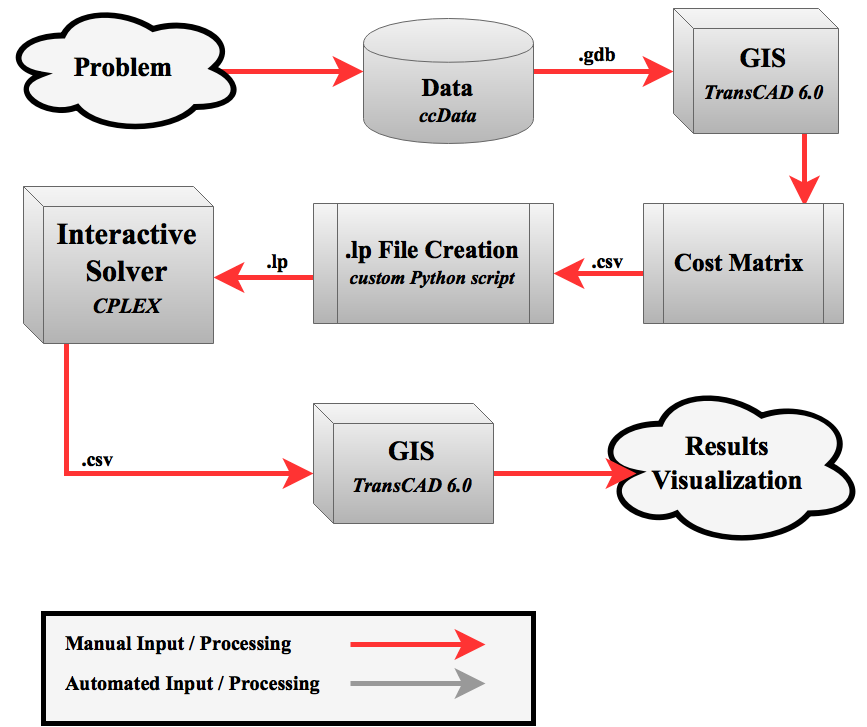

In [4]:
# Manual Conceptual Model
#My_Manual = IPd.Image(path+'/Manual_Diagram.png')
My_Manual = IPd.Image('/Users/jgaboardi/Dropbox/Apps/drawio/Manual_Diagram.png')
My_Manual

## <b>So why do things differently?

When solving spatial problems in a GIS, there are lots of files to keep track of and lots of button clicking. This can lead to compounded errors at every stage in the process.

-------------------

# 2. &nbsp;&nbsp;&nbsp;&nbsp;<u>Demonstration</u>

The following flowchart is a conceptual model of my current workflow.  This workflow mimics the one described above, but the processes within are largely automated to minimize human error in data handling, etc.

This workflow will be demonstrated next.

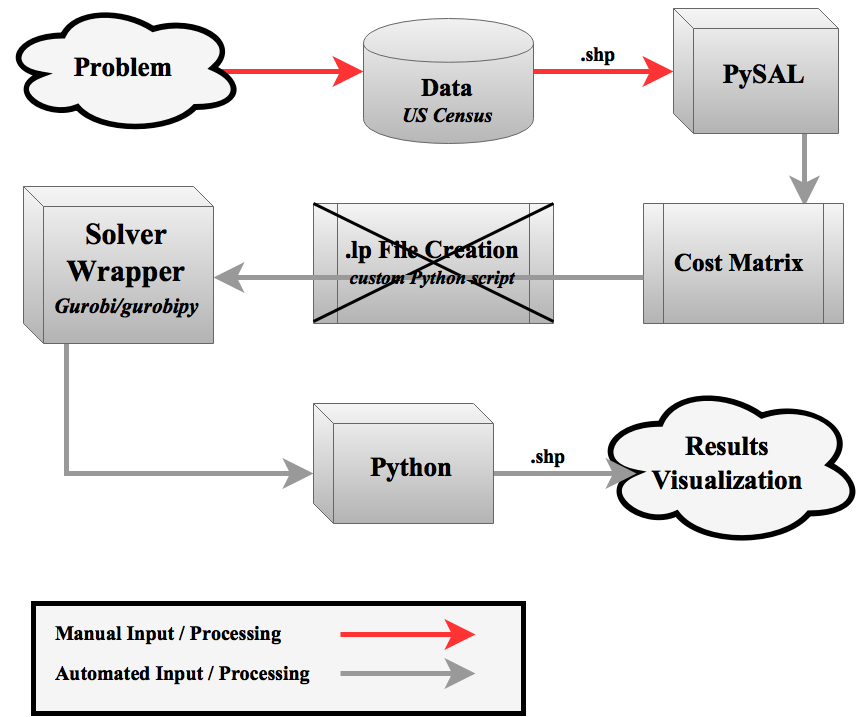

In [5]:
# Automated Conceptual Model
#My_Auto = IPd.Image(path+'/Auto_Diagram.png')
My_Auto = IPd.Image('/Users/jgaboardi/Dropbox/Apps/drawio/Auto_Diagram.png')
My_Auto

## <u>Imports & Specs</u>

In [6]:
from collections import OrderedDict
import geopandas as gpd
import gurobipy as gbp
import networkx as nx
import numpy as np
import pysal as ps
import shapefile as shp
%pylab inline

print '********************************************************'
print ' | Platform Specs:                                    |'
print ' |  | OS X v', platform.mac_ver()[0],'                                 |'
print ' |  | Processor: ', platform.processor(), '                               |'
print ' |  | Machine: ', platform.machine(), '                               |'
print ' |  | Python: ', platform.python_version(), '                                 |'
print ' |  | PySAL: ', ps.version, '                              |'
print ' |  | Gurobi: ', gbp.gurobi.version(),'                             |'
print '********************************************************'
print ' |  | Date/Time --------- ', dt.datetime.now(), '|'
print '********************************************************'

Populating the interactive namespace from numpy and matplotlib
********************************************************
 | Platform Specs:                                    |
 |  | OS X v 10.11.1                                  |
 |  | Processor:  i386                                |
 |  | Machine:  x86_64                                |
 |  | Python:  2.7.9                                  |
 |  | PySAL:  1.11.0dev                               |
 |  | Gurobi:  (6, 5, 0)                              |
********************************************************
 |  | Date/Time ---------  2015-11-04 19:33:45.066364 |
********************************************************


## <u>PySAL</u>

In [7]:
print 'PySAL'
print dir(ps)
print '\nPySAL.Network'
print dir(ps.Network)

PySAL
['Box_Plot', 'DistanceBand', 'Equal_Interval', 'Fisher_Jenks', 'G', 'G_Local', 'Gamma', 'Geary', 'IOHandlers', 'Jenks_Caspall', 'Jenks_Caspall_Forced', 'Jenks_Caspall_Sampled', 'Join_Counts', 'K_classifiers', 'Kernel', 'LISA_Markov', 'MISSINGVALUE', 'Markov', 'Max_P_Classifier', 'Maximum_Breaks', 'Maxp', 'Maxp_LISA', 'Moran', 'Moran_BV', 'Moran_BV_matrix', 'Moran_Local', 'Natural_Breaks', 'Network', 'NetworkF', 'NetworkG', 'NetworkK', 'Percentiles', 'Quantiles', 'SpatialTau', 'Spatial_Markov', 'Std_Mean', 'Tau', 'Theil', 'TheilD', 'TheilDSim', 'Theta', 'User_Defined', 'W', 'WSP', '__builtins__', '__doc__', '__file__', '__name__', '__package__', '__path__', 'adaptive_kernelW', 'adaptive_kernelW_from_shapefile', 'base_path', 'bin', 'bin1d', 'binC', 'block_weights', 'buildContiguity', 'build_lattice_shapefile', 'cg', 'check_version', 'comb', 'common', 'config', 'config_path', 'core', 'datetime', 'directional', 'ergodic', 'esda', 'examples', 'full', 'gadf', 'hexLat2W', 'higher_order'

-----------------

## 2.1 &nbsp;&nbsp;&nbsp;&nbsp;<u>Data preparation and creation</u>

### 2.1.1 &nbsp;&nbsp;&nbsp;&nbsp;<u>Instantiate a network</u>

First, I start out by instantiating a network by reading a shapefile in as a network object with `PySAL`.  I use Waverly Hills, a smallish neighborhood in Tallahassee, FL where quite a few professors at Florida State University own homes.  This shapefile was clipped from a US Census TIGER/Line file (US Census Bureau 2015).

Note: Steps 3.1.3 through 3.1.7 are needed to create a toy dataset of aggregated population demand points (i.e. census blocks) and service facilities (i.e. pay phones). These steps are eliminated when reading in actual datasets.

In [9]:
# Instanitate network of Waverly Hills
ntw = ps.Network('Waverly/Waverly.shp')

### 2.1.2 &nbsp;&nbsp;&nbsp;&nbsp;<u>Instantiate all graphs to be drawn</u>

Next, I instantiate the graphs to be drawn for visualization. This includes a representation of edges comprising the road network and nodes for the demand and service nodes. `NetworkX` is utilized for this step.

In [10]:
# Roads and Nodes
g = nx.Graph()

# Graph of Roads and Nodes
g1 = nx.MultiGraph()

# Clients
GRAPH_client = nx.Graph()

# Snapped Clients
g_client = nx.Graph()

# Service
GRAPH_service = nx.Graph()

# Snapped Service
g_service = nx.Graph()

## Optimized Locations
# Set Cover
setcover_g = nx.Graph()

# p-Median
median_g = nx.Graph()

# p-Center
center_g = nx.Graph()

### 2.1.3 &nbsp;&nbsp;&nbsp;&nbsp;<u>Create Bounding Box from the roads in 'Waverly.shp'</u>

In [11]:
#shp_W = pd
shp_W = ps.open('Waverly/Waverly.shp')
shp_W.bbox

[-84.280694, 30.450132999999997, -84.24955399999999, 30.507330999999997]

In [12]:
# Client latitude
lat_client = np.random.uniform(shp_W.bbox[0], shp_W.bbox[2], 100)

# Client longitude
lon_client = np.random.uniform(shp_W.bbox[1], shp_W.bbox[3], 100)

# Service latitude
lat_service = np.random.uniform(shp_W.bbox[0], shp_W.bbox[2], 50)

# Service longitude
lon_service = np.random.uniform(shp_W.bbox[1], shp_W.bbox[3], 50)

In [13]:
# Client lat/lon coordinates
rand_coords_client = map(list, zip(lat_client, lon_client))

# Service lat/lon coordinates
rand_coords_service = map(list, zip(lat_service, lon_service))

In [14]:
# Empty Clients dictionary
points_client = {}

# Empty Service dictionary
points_service = {}

In [15]:
# CLIENT with {id: [lon, lat], } format
for idx, coordsC in enumerate(rand_coords_client):
    GRAPH_client.add_node(idx)
    points_client[idx] = coordsC
    GRAPH_client.node[idx] = coordsC

# SERVICE with {id: [lon, lat], } format  
for idx, coords in enumerate(rand_coords_service):
    GRAPH_service.add_node(idx)
    points_service[idx] = coords
    GRAPH_service.node[idx] = coords

In [29]:
Waverly = gpd.read_file('Waverly/Waverly.shp')


#CLI = gpd.GeoDataFrame((rand_coords_client[i] for i in rand_coords_client), columns=['geometry'])

In [31]:
print Waverly.crs

{'init': u'epsg:4269'}


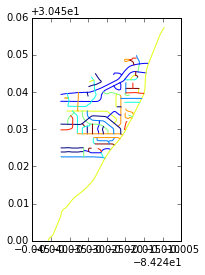

In [32]:
Waverly.plot()

In [19]:
CLI

,geometry
0,-84.271188
1,30.496761


In order to create fake demand and service nodes for this toy problem I create a bounding latitude and longitude box from the extremes of the 'Waverly.shp' of the Waverly Hills neighborhood. The total area is roughly 1.5 square miles.

In [ ]:
# Open Waverly.shp
#shp_W = ps.open('Waverly/Waverly.shp')

# Create bounding box from Waverly.shp
#shp_W.bbox

### 2.1.4 &nbsp;&nbsp;&nbsp;&nbsp;<u>Create numpy arrays of random floats within a  bounding box</u>

Within the bounding box I create lists of 100 random real numbers for the latitude and longitude of demand points (clients), then 50 random real numbers for the latitude and longitude of the service points with `Numpy`.

In [ ]:
# Client latitude
lat_client = np.random.uniform(shp_W.bbox[0], shp_W.bbox[2], 100)

# Client longitude
lon_client = np.random.uniform(shp_W.bbox[1], shp_W.bbox[3], 100)

# Service latitude
lat_service = np.random.uniform(shp_W.bbox[0], shp_W.bbox[2], 50)

# Service longitude
lon_service = np.random.uniform(shp_W.bbox[1], shp_W.bbox[3], 50)

### 2.1.5 &nbsp;&nbsp;&nbsp;&nbsp;<u>Zip the latitude and longitude lists together</u>

Next, these 4 lists are zipped together to form 2: a list of client lat/lons and a list and service lat/lons

In [ ]:
# Client lat/lon coordinates
rand_coords_client = map(list, zip(lat_client, lon_client))

# Service lat/lon coordinates
rand_coords_service = map(list, zip(lat_service, lon_service))

### 2.1.6 &nbsp;&nbsp;&nbsp;&nbsp;<u>Create Empty Random Points Dictionaries</u>

Dictionaries are instantiated to house the point location data for the client and service facilities.

In [ ]:
# Empty Clients dictionary
points_client = {}

# Empty Service dictionary
points_service = {}

### 2.1.7 &nbsp;&nbsp;&nbsp;&nbsp;<u>Fill dictionaries of random roints</u>

The dictionaries that have just been created are now filled with the ids and lat/lons of the points.

In [ ]:
# CLIENT with {id: [lon, lat], } format
for idx, coords in enumerate(rand_coords_client):
    GRAPH_client.add_node(idx)
    points_client[idx] = coords
    GRAPH_client.node[idx] = coords

# SERVICE with {id: [lon, lat], } format  
for idx, coords in enumerate(rand_coords_service):
    GRAPH_service.add_node(idx)
    points_service[idx] = coords
    GRAPH_service.node[idx] = coords

### 2.1.8 &nbsp;&nbsp;&nbsp;&nbsp;<u>Draw roads, simplified network, and random client & service nodes</u>

The following is a visualization of the data I have just created and the roads in Waverly Hills using `matplotlib`.  The roads and nodes are derived for network object created in [3.1.1].

Nodes in pink represent the actual intersections and the roads are represented in light red. The simplified network (connecting graph nodes) is gray and the remaining graph nodes (where a choice in forward destination is possible) are red.  These are necessary for determination of a shortest path and greatly would diminish the computational time (once we work the code out).

The client nodes are represented in blue and the service nodes are represented in cyan.

2015-11-04 19:47:14.243682


AttributeError: 'tuple' object has no attribute 'update'

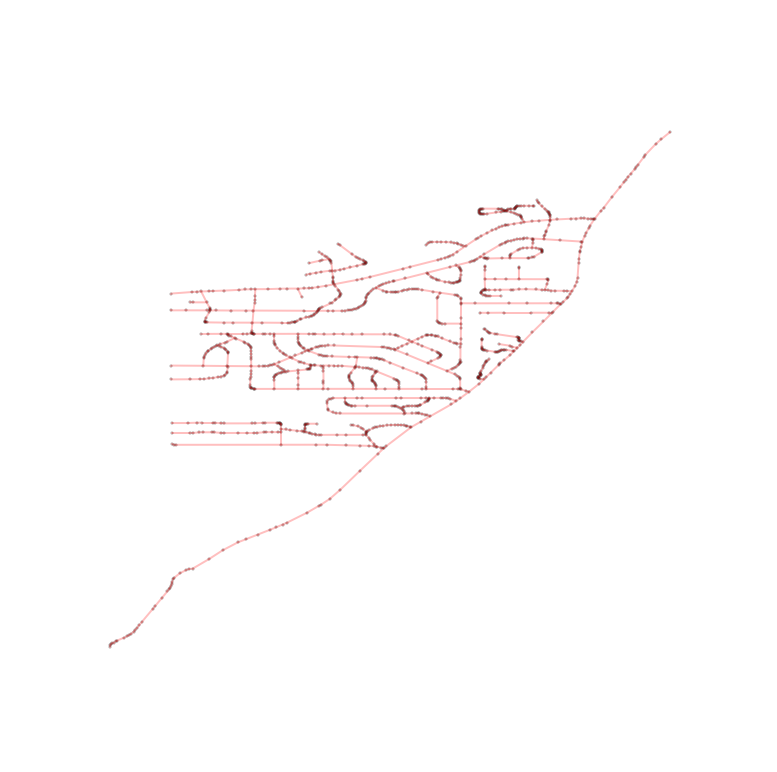

In [34]:
print dt.datetime.now()

#Instantiate Figure
figsize(10,10)

#Draw Graph of Actual Nodes and Roads
for e in ntw.edges:
    g.add_edge(*e)
nx.draw(g, ntw.node_coords, node_size=5, alpha=0.25, edge_color='r', width=2)

#Draw only unique edges in graph
for e in ntw.graphedges:
    g1.add_edge(*e)
    # highlights cases where start and end node are the same
    if e[0]==e[1]:
        g1.add_node(e[0])
for node_id in g1.node:
    g1.node[node_id] = ntw.node_coords[node_id]
nx.draw(g1, ntw.node_coords, node_size=20, alpha=0.5)

# Draw Graph of Random Client Points
nx.draw(GRAPH_client, points_client, 
    node_size=75, alpha=1, node_color='b')

# Draw Graph of Random Service Points
nx.draw(GRAPH_service, points_service, 
    node_size=100, alpha=1, node_color='c')

# Legend (Ordered Dictionary) from collections
LEGEND = OrderedDict()
LEGEND['Network Nodes']=g
LEGEND['Roads']=g
LEGEND['Graph Vertices']=g1
LEGEND['Graph Edges']=g1
LEGEND['Client Nodes']=GRAPH_client
LEGEND['Service Nodes']=GRAPH_service
legend(LEGEND, 
       loc='lower right', 
       fancybox=True, 
       framealpha=0.5,
       scatterpoints=1)

# Title
title('Waverly Hills\n Tallahassee, Florida', family='Times New Roman', 
      size=40, color='k', backgroundcolor='w', weight='bold')

# North Arrow and 'N' --> Must be changed for different spatial resolutions, etc.
arrow(-84.281, 30.507, 0.0, 0.01, width=.0003, head_width=0.0012, 
          head_length=0.002, fc='k', ec='k',alpha=0.75,)
annotate('N', xy=(-84.2815, 30.52), fontstyle='italic', fontsize='xx-large',
            fontweight='heavy', alpha=0.75)

### 2.1.9 &nbsp;&nbsp;&nbsp;&nbsp;<u>Create weights at nodes and sum</u>

In order to solve the population weighted problem in this demonstration, the <i>p</i>-median problem, I will `Numpy` to generate a list of 100 random integers [5-50] to represent population at each client node. 

In [35]:
# Client Weights for demand
Ai = np.random.randint(5, 50, len(rand_coords_client))
Ai = Ai.reshape(len(Ai),1)

# Sum of Weights (Total Demand) 
AiSum = np.sum(Ai)

### 2.1.10 &nbsp;&nbsp;&nbsp;&nbsp;<u>Instantiate client and service shapefiles</u>

Using the python package `shapefile`, I instantiate `.shp` files of the client and service location data that was created above.

In [36]:
# Client Shapefile
client = shp.Writer(shp.POINT)
# Add Random Points
for i,j in rand_coords_client:
    client.point(i,j)
# Add Fields
client.field('client_ID')
client.field('Weight')
client.field('LAT')
client.field('LON')
counter = 0
for i in range(len(rand_coords_client)):
    counter = counter + 1
    client.record('client_' + str(counter), Ai[i], lat_client[i], lon_client[i])
# Save Shapefile    

'''new path'''

client.save('/Users/jgaboardi/Dropbox/NARSC/NARSC_Portland_2015/Discrete_Location/shapefiles/RandomPoints_CLIENT')

#Service Shapefile
service = shp.Writer(shp.POINT)
# Add Random Points
for i,j in rand_coords_service:
    service.point(i,j)
# Add Fields
service.field('y_ID')
service.field('x_ID')
service.field('LAT')
service.field('LON')
counter = 0
for i in range(len(rand_coords_service)):
    counter = counter + 1
    service.record('y' + str(counter), 'x' + str(counter), lat_service[i], lon_service[i])
# Save Shapefile    
service.save('/Users/jgaboardi/Dropbox/NARSC/NARSC_Portland_2015/Discrete_Location/shapefiles/RandomPoints_SERVICE')

In [38]:
#CLIENT = 
SERVICE = gpd.read_file('/Users/jgaboardi/Dropbox/NARSC/NARSC_Portland_2015/Discrete_Location/shapefiles/RandomPoints_SERVICE.shp')

               LAT            LON  \
0   -84.2669057793  30.5062788256   
1    -84.271222492  30.5059168393   
2   -84.2577492136  30.4613104219   
3   -84.2702714778  30.4603788701   
4   -84.2498207074  30.4899871189   
5   -84.2771447168  30.4674037923   
6   -84.2720844301  30.4604074659   
7   -84.2649316461  30.5011689574   
8   -84.2583305042   30.466486532   
9   -84.2604811013  30.4647312036   
10  -84.2804860063  30.4975183001   
11  -84.2543847085  30.4552534578   
12  -84.2748541051  30.5054951193   
13  -84.2661800065  30.4823343591   
14  -84.2764350689  30.4640137755   
15   -84.279377795  30.4510279797   
16  -84.2531702536  30.4870685876   
17   -84.253339004  30.4894613455   
18  -84.2563824645  30.4836148071   
19   -84.255071819  30.4821769173   
20  -84.2597055933  30.4880072303   
21  -84.2719813105  30.4891990943   
22  -84.2735893719  30.5066355458   
23  -84.2707536866  30.4574282759   
24   -84.280162641  30.4668214695   
25  -84.2750391409  30.4922700921   
2

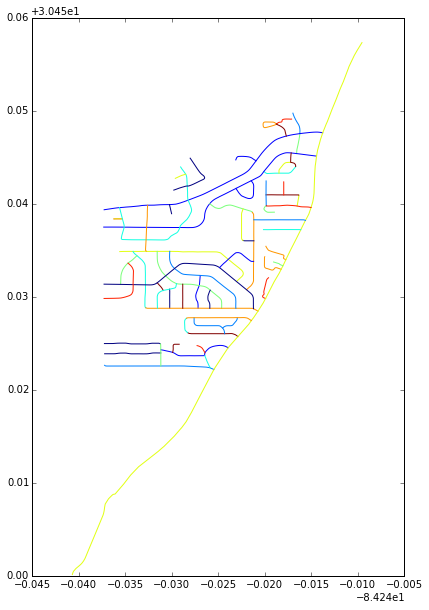

In [43]:
print SERVICE
Waverly.append(SERVICE)
print Waverly
Waverly.plot()

### 2.1.11 &nbsp;&nbsp;&nbsp;&nbsp;<u>Snap Observations to NTW</u>

Next, I snap the client and service observations to the network with the `ntw.snapobservations` method within the instantiated network object. This allows for the creation of a distance matrix later.

In [ ]:
t1 = time.time()
Snap_C = ntw.snapobservations('shapefiles/RandomPoints_CLIENT.shp', 
                     'Rand_Points_CLIENT', attribute=True)
Snap_S = ntw.snapobservations('shapefiles/RandomPoints_SERVICE.shp', 
                     'Rand_Points_SERVICE', attribute=True)
print round(time.time()-t1, 4), 'seconds'

### 2.1.12 &nbsp;&nbsp;&nbsp;&nbsp;<u>Draw NTW, snapped coords, & random coords</u>

When the graph is redrawn we can the client and service location in their original locations represented by the smaller points, and the network-snapped location represented with larger points.

In [ ]:
# Instantiate Figure
figsize(10,10)
# Draw Graph of Roads
for e in ntw.edges:
    g.add_edge(*e)
nx.draw(g, ntw.node_coords, node_size=5, alpha=0.25, edge_color='r', width=2)
# Draw Graph of Snapped Client Nodes
g_client = nx.Graph()
for p,coords in ntw.pointpatterns['Rand_Points_CLIENT'].snapped_coordinates.iteritems():
    g_client.add_node(p)
    g_client.node[p] = coords
nx.draw(g_client, ntw.pointpatterns['Rand_Points_CLIENT'].snapped_coordinates, 
        node_size=100, alpha=1, node_color='b')
# Draw Graph of Snapped Service Nodes
g_service = nx.Graph()
for p,coords in ntw.pointpatterns['Rand_Points_SERVICE'].snapped_coordinates.iteritems():
    g_service.add_node(p)
    g_service.node[p] = coords
nx.draw(g_service, ntw.pointpatterns['Rand_Points_SERVICE'].snapped_coordinates, 
        node_size=100, alpha=1, node_color='c')
# Draw Graph of Random Client Points
nx.draw(GRAPH_client, points_client, 
    node_size=20, alpha=1, node_color='y')
# Draw Graph of Random Client Points
nx.draw(GRAPH_service, points_service, 
    node_size=20, alpha=1, node_color='w')

# Legend (Ordered Dictionary)
LEGEND = OrderedDict()
LEGEND['Network Nodes']=g
LEGEND['Roads']=g
LEGEND['Snapped Client']=g_client
LEGEND['Snapped Service']=g_service
LEGEND['Client Nodes']=GRAPH_client
LEGEND['Service Nodes']=GRAPH_service
legend(LEGEND, loc='lower right', fancybox=True, framealpha=0.5, scatterpoints=1)
# Title
title('Waverly Hills\n Tallahassee, Florida', family='Times New Roman', 
      size=40, color='k', backgroundcolor='w', weight='bold')
# North Arrow and 'N' --> Must be changed for different spatial resolutions, etc.
arrow(-84.281, 30.507, 0.0, 0.01, width=.0003, head_width=0.0012, 
          head_length=0.002, fc='k', ec='k',alpha=0.75,)
annotate('N', xy=(-84.2815, 30.52), fontstyle='italic', fontsize='xx-large',
            fontweight='heavy', alpha=0.75)

### <b>2.1.13 &nbsp;&nbsp;&nbsp;&nbsp;<u>Create distance matrices</u>

Finally, I create a client to service distance matrix with `ntw.allneighbordistances()` from the instantiated network object of Waverly Hills [`Waverly.shp`].  The matrix is 100x50 and the values are converted from decimal degrees to miles. 

A current limitation of this is run time which is hindered by the geographic size of the network. When tested with much larger client and service point sets the `Dijkstra` algorithm ran in similar time.  This demonstrates the limitation of calculating a shortest-path with the actual road network.  As an improvement,


we need to refactor the `Dijkstra` and also calculate it on the simplified graph to see decreases in run time. The run time will decreases because there are far fewer nodes and edges in the simplified graph.

In [ ]:
t1 = time.time()

# Define Client to Service Matrix Function
def c_s_matrix():
    global All_Dist_MILES
    All_Neigh_Dist = ntw.allneighbordistances(sourcepattern=ntw.pointpatterns['Rand_Points_CLIENT'],
                                             destpattern=ntw.pointpatterns['Rand_Points_SERVICE'])
    All_Dist_MILES = All_Neigh_Dist * float(10000/90) * 0.6214 

# Call Client to Service Matrix Function
c_s_matrix()    

seconds = round(time.time()-t1, 4)    
print seconds, 'seconds'
print 'Client to Service Matrix Shape --> ', All_Dist_MILES.shape

------------------------

## 2.2 &nbsp;&nbsp;&nbsp;&nbsp;<u>Mathematical Optimization</u>

### 2.2.1a &nbsp;&nbsp;&nbsp;&nbsp;<u>Set Cover test [<i>S</i> = 1.25 miles]</u>

The set cover location problem, also known as the SCLP, is a fundamental facility location problem (Beasley 1987; Daskin 1995; Beasley and Chu 1996).  The objective of the SCLP is to minimize the number of service facilities to site while achieving complete (100%) coverage of client nodes.

## <u>Minimize</u>

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum_{j=1}^n d_j x_j$

## <u>Subject to</u>

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum_{j=1}^n a_{ij} x_j \geq 1,$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $i = 1 \in n$

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle x_j \in (0,1)$  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $j = 1 \in  m$


## <u>where</u>
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$i$ = a specific origin
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$j$ = a specific destination
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$n$ = the set of origins
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$m$ = the set of destinations
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$x_i$ = the decision variable at each node in the matrix
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$a_{ij}$ = binary matrix describing the coverage of each node

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <u>where</u>

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;− $a_{ij}$ = $1 \forall i, j \ni d_{ij} \geq S$ ($S$ is user defined) 

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;− $a_{ij} $ = $0$ otherwise

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$d_{ij}$ = distance from $i$th origin to $j$th destination

-----

- Adapted from:
#### Daskin, M. S. 1995. Network and Discrete Location: Models, Algorithms, and Applications. Hoboken, NJ, USA: John Wiley & Sons, Inc.

In [ ]:
# Define the Set Cover function
def gbpSCLP():    
    
    t1 = time.time()
    
    # Define Global Records Variable
    global NEW_Records_SCLP
    
    #     1. Read In Data
    # Cost Matrix
    Cij = All_Dist_MILES
    # Create Aij: Determine Aij (nodes within S)
    # S --> 1 = served; 0 = unserved
    S = 1.25
    # Aij
    Aij = []
    for i in np.nditer(Cij):
        if i <= S:
            outtext = 1
        else:
            outtext = 0
        Aij.append(outtext)
    rows, cols = Cij.shape
    
    # Transform Aij into an array and resphape to match with Cij
    Aij = np.array(Aij)
    Aij = Aij.reshape(len(Cij),len(Cij[0]))
    
    
    client_nodes = range(len(Cij))
    service_nodes = range(len(Cij[0]))

    #     2. Create Model, Set MIP Focus, Add Variables, & Update Model
    mSCLP = gbp.Model(" -- SCLP -- ")
    
    # Set MIP Focus to 2 for optimality
    gbp.setParam('MIPFocus', 2)

    # Add Service Decision Variables (j)
    serv_var = []
    for dest in service_nodes:
        serv_var.append(mSCLP.addVar(vtype=gbp.GRB.BINARY,
                                    ub = 1,
                                    name='x'+str(dest+1)))
    # Update Model Variables
    mSCLP.update()       

    #     3. Set Objective Function
    mSCLP.setObjective(gbp.quicksum(serv_var[dest] 
                                for dest in service_nodes), 
                                gbp.GRB.MINIMIZE)

    #     4. Add Constraints 
    # Add Coverage Constraints  
    for orig in client_nodes:
        mSCLP.addConstr(gbp.quicksum(Aij[orig][dest]*serv_var[dest] 
                                for dest in service_nodes) >= 1)        

    #     5. Optimize and Print Results
    # Solve
    try:
        mSCLP.optimize()
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
        print '   ################################################################'
        print ' < ISSUE : ', e, ' >'
        print '   ################################################################'
    
    # Write LP
    mSCLP.write('/Users/jgaboardi/Dropbox/NARSC/NARSC_Portland_2015/Discrete_Location/LP_Files/WaverlySCLP.lp')
    t2 = time.time()-t1
    
    # Record and Display Results
    print '\n*****************************************************************************************'
    selected = []
    dbf1 = ps.open('shapefiles/RandomPoints_SERVICE.dbf')
    NEW_Records_SCLP = []
    for v in mSCLP.getVars():
        if v.x > 0:
            var = '%s' % v.VarName
            selected.append(v.x)
            for i in range(dbf1.n_records):
                if var in dbf1.read_record(i):
                    x = dbf1.read_record(i)
                    NEW_Records_SCLP.append(x)
                else:
                    pass
            print '    |                                                ', var
    print '    | Selected Facility Locations ------------------  ^^^^ '
    print '    | Coverage (S) in miles ------------------------ ', S
    print '    | Client Nodes --------------------------------- ', len(client_nodes)
    print '    | Facilities needed 100% coverage of clients --- ', len(selected)
    print '    | Real Time to Optimize (sec.) ----------------- ', t2
    print '    | Date/Time ------------------------------------ ', dt.datetime.now()
    print '*****************************************************************************************'
    print ' -- Set Cover Location Problem -- '
    
# Call SCLP Function
try:
    gbpSCLP()
    print '\nJames Gaboardi, 2015'
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
    print '   ################################################################'
    print ' < ISSUE : ', e, ' >'
    print '   ################################################################'

### 2.2.1b&nbsp;&nbsp;&nbsp;&nbsp; <u>Instantiate selected Set Cover location shapefile</u>

Following optimization, I created a new shapefile of the selected candidate service locations.

In [ ]:
# Define SCLP shapefile function
def Create_SCLP():
    try:
        # Instantiate SCLP shapefile
        SHP_SetCover = shp.Writer(shp.POINT)
        # Add Points
        for idy,idx,x,y in NEW_Records_SCLP:
            SHP_SetCover.point(float(x), float(y))
        # Add Fields
        SHP_SetCover.field('y_ID')
        SHP_SetCover.field('x_ID')
        SHP_SetCover.field('LAT')
        SHP_SetCover.field('LON')
        # Add Records
        for idy,idx,x,y in NEW_Records_SCLP:
            SHP_SetCover.record(idy,idx,x,y)
        # Save Shapefile    
        SHP_SetCover.save('/Users/jgaboardi/Dropbox/NARSC/NARSC_Portland_2015/Discrete_Location/shapefiles/Selected_Locations_SetCover')
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
        print '   ################################################################'
        print ' < ISSUE : ', e, ' >'
        print '   ################################################################'

# Call SCLP shapefile function
try:
    Create_SCLP()
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
    print '   ################################################################'
    print ' < ISSUE : ', e, ' >'
    print '   ################################################################'

----------------------------

### 2.2.2a&nbsp;&nbsp;&nbsp;&nbsp;  <u><i>p</i>-Median test [<i>p</i> = 2]</u>

The <i>p</i>-median problem (PMP), also known as the minisum problem, was first proposed by Hakimi in the 1960s and has been utilized in wide-ranging research topics such as Mathematics and Emergency Management since then (Hakimi 1964; Teitz and Bart 1968; Tansel, Francis, and Lowe 1983; Daskin 1995; Horner and Widener 2010; Kalcsics et al. 2014).  This model sites <i>p</i> facilities with an objective of minimizing the total travel cost by siting facilities nearest to the greatest amount of demand.  Weighting decision variables with population, for example, does this.  Efficiency (lowest travel cost) is the key to the PMP. 


## <u>Minimize</u>

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum_{i \in 1}^n\sum_{j\in 1}^m a_i c_{ij} x_{ij}$

## <u>Subject to</u>

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum_{j\in m} x_{ij}  = 1 ,$&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $\forall i \in n$

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum_{i \in n} y_j = p$

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{ij} - y_j \geq 0,$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\forall i \in n, j \in m$

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{ij}, y_j \in (0,1)$ &nbsp;&nbsp;&nbsp;&nbsp; $\forall i \in n , j \in m$

## <u>where</u>

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$i$ = a specific origin
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$j$ = a specific destination
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$n$ = the set of origins
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$m$ = the set of destinations
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$a_i$ = weight at each node
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$c_{ij}$ = travel costs between nodes
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$x_{ij}$ = the decision variable at each node in the matrix
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$y_j$ = nodes chosen as service facilities
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$p$ = the number of facilities to be sited

-----

- Adapted from:
#### Daskin, M. S. 1995. Network and Discrete Location: Models, Algorithms, and Applications. Hoboken, NJ, USA: John Wiley & Sons, Inc.

In [ ]:
# define p-Median function
def gbpPMP():
    
    t1 = time.time()
    
    # Define Global Variables
    global Ai
    global AiSum
    global NEW_Records_PMP 
    
    #     1. Data
    # Demand
    Ai = Ai
    # Demand Sum
    AiSum = AiSum
    # Travel Costs
    Cij = All_Dist_MILES
    # Weighted Costs
    Sij = Ai * Cij
    # Total Client and Service nodes
    client_nodes = range(len(Sij))
    service_nodes = range(len(Sij[0]))
    
    #     2. Create Model, Set MIP Focus, Add Variables, & Update Model
    # Instantiate Model
    mPMP = gbp.Model(' -- p-Median -- ')
    
    # Set MIP focus to 'Optimal'
    gbp.setParam('MIPFocus', 2)

    # Add Client Decision Variables (iXj)
    client_var = []
    for orig in client_nodes:
        client_var.append([])
        for dest in service_nodes:
            client_var[orig].append(mPMP.addVar(vtype=gbp.GRB.BINARY, 
                                                obj=Sij[orig][dest], 
                                                name='x'+str(orig+1)+'_'+str(dest+1)))
    
    # Add Service Decision Variables (j)
    serv_var = []
    for dest in service_nodes:
        serv_var.append([])
        serv_var[dest].append(mPMP.addVar(vtype=gbp.GRB.BINARY, 
                                        name='y'+str(dest+1)))
    
    # Update the model
    mPMP.update()
    
    #     3. Set Objective Function
    mPMP.setObjective(gbp.quicksum(Sij[orig][dest]*client_var[orig][dest] 
                            for orig in client_nodes for dest in service_nodes), 
                            gbp.GRB.MINIMIZE)
    
    
    #     4. Add Constraints
    # Assignment Constraints
    for orig in client_nodes:
        mPMP.addConstr(gbp.quicksum(client_var[orig][dest] 
                            for dest in service_nodes) == 1)
    # Opening Constraints
    for orig in service_nodes:
        for dest in client_nodes:
            mPMP.addConstr((serv_var[orig][0] - client_var[dest][orig] >= 0))
    
    # Facility Constraint
    mPMP.addConstr(gbp.quicksum(serv_var[dest][0] for dest in service_nodes) == 2)
    
    #     5. Optimize and Print Results
    # Solve
    try:
        mPMP.optimize()
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
        print '   ################################################################'
        print ' < ISSUE : ', e, ' >'
        print '   ################################################################'
    
    # Write LP
    mPMP.write('/Users/jgaboardi/Dropbox/NARSC/NARSC_Portland_2015/Discrete_Location/LP_Files/WaverlyPMP.lp')
    t2 = time.time()-t1
    
    # Record and Display Results
    print '\n*************************************************************************'
    selected = []
    dbf1 = ps.open('shapefiles/RandomPoints_SERVICE.dbf')
    NEW_Records_PMP = []
    for v in mPMP.getVars():
        if 'x' in v.VarName:
            pass
        elif v.x > 0:
            var = '%s' % v.VarName
            selected.append(var)
            for i in range(dbf1.n_records):
                if var in dbf1.read_record(i):
                    x = dbf1.read_record(i)
                    NEW_Records_PMP.append(x)
                else:
                    pass
            print '    |                                            ', var
    print '    | Selected Facility Locations --------------  ^^^^ '
    print '    | Candidate Facilities [p] ----------------- ', len(selected)
    val = mPMP.objVal
    print '    | Objective Value (miles) ------------------ ', val
    avg = float(mPMP.objVal)/float(AiSum)
    print '    | Avg. Value / Client (miles) -------------- ', avg
    print '    | Real Time to Optimize (sec.) ------------- ', t2
    print '    | Date/Time -------------------------------- ', dt.datetime.now()
    print '*************************************************************************'
    print ' -- The p-Median Problem -- '
    
# Call p-Median Function   
try:
    gbpPMP()
    print '\nJames Gaboardi, 2015'
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
    print '   ################################################################'
    print ' < ISSUE : ', e, ' >'
    print '   ################################################################'

### 2.2.2b&nbsp;&nbsp;&nbsp;&nbsp; <u>Instantiate Selected <i>p</i>-median shapefile</u>

Following optimization, I created a new shapefile of the selected candidate service locations.

In [ ]:
# define PMP shapefile function
def Create_PMP():
    try:
        # Instantiate Shapefile
        SHP_Median = shp.Writer(shp.POINT)
        # Add Points
        for idy,idx,x,y in NEW_Records_PMP:
            SHP_Median.point(float(x), float(y))
        # Add Fields
        SHP_Median.field('y_ID')
        SHP_Median.field('x_ID')
        SHP_Median.field('LAT')
        SHP_Median.field('LON')
        # Add Records
        for idy,idx,x,y in NEW_Records_PMP:
            SHP_Median.record(idy,idx,x,y)
        # Save Shapefile    
        SHP_Median.save('/Users/jgaboardi/Dropbox/NARSC/NARSC_Portland_2015/Discrete_Location/shapefiles/Selected_Locations_Pmedian')
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
        print '   ################################################################'
        print ' < ISSUE : ', e, ' >'
        print '   ################################################################'

# Call PMP shapefile function
try:
    Create_PMP()
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
    print '   ################################################################'
    print ' < ISSUE : ', e, ' >'
    print '   ################################################################'

----------------------

### 2.2.3a  &nbsp;&nbsp;&nbsp;&nbsp;<u><i>p</i>-Center test [<i>p</i> = 2]</u>

The <i>p</i>-center problem (PCP), also referred to as the minimax problem, sites facilities with a focus on equity and has been widely utilized in research as a counter-measure to the efficiency-based <i>p</i>-median problem.  The objective of the PCP is the minimization of the maximum (worst-case) travel cost from client nodes to service facilities (Minieka 1970; Shier 1977; Tansel, Francis, and Lowe 1983; Horner and Widener 2010).

## <u>Minimize</u>

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $W$

## <u>Subject to</u>

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum_{j\in m} x_{ij} = 1,$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   $\forall i \in n$

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum_{i \in n} y_j = p$

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{ij} - y_j \geq 0,$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $\forall i\in n, j \in m$

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle W \geq \sum_{j \in m} c_{ij} x_{ij}$&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\forall i \in n$

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{ij}, y_j \in (0,1)$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\forall i \in n, j \in m$

## <u>where</u>

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$W$ = the maximum travel cost between client and service nodes
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$i$ = a specific origin
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$j$ = a specific destination
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$n$ = the set of origins
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$m$ = the set of destinations
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$a_i$ = weight at each node
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$c_{ij}$ = travel costs between nodes
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$x_{ij}$ = the decision variable at each node in the matrix
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$y_j$ = nodes chosen as service facilities
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;−	$p$ = the number of facilities to be sited

-----

- Adapted from:
#### Daskin, M. S. 1995. Network and Discrete Location: Models, Algorithms, and Applications. Hoboken, NJ, USA: John Wiley & Sons, Inc.

In [ ]:
# define PCP shapefile function
def gbpPCP():
    
    t1 = time.time()
    
    # Define Global Variables
    global Cij 
    global NEW_Records_PCP
    
    #     1. Data
    Cij = All_Dist_MILES
    
    # Total Client and Service nodes
    client_nodes = range(len(Cij))
    service_nodes = range(len(Cij[0]))
    
    #    2. Create Model, Set MIP Focus, Add Variables, & Update Model
    # Instantiate Model
    mPCP = gbp.Model(' -- P-Center -- ')
    # Set MIP focus to 'Optimal'
    gbp.setParam('MIPFocus', 2)
    
    # Add Client Decision Variables (iXj)
    client_var = []
    for orig in client_nodes:
        client_var.append([])
        for dest in service_nodes:
            client_var[orig].append(mPCP.addVar(vtype=gbp.GRB.BINARY, 
                                                obj=Cij[orig][dest], 
                                                name='x'+str(orig+1)+'_'+str(dest+1)))
    # Add Service Decision Variables (j)
    serv_var = []
    for dest in service_nodes:
        serv_var.append([])
        serv_var[dest].append(mPCP.addVar(vtype=gbp.GRB.BINARY, 
                                        name='y'+str(dest+1)))
    
    # Add the Maximum travel cost variable
    W = mPCP.addVar(vtype=gbp.GRB.CONTINUOUS,
                name='W')        
    
    # Update the model
    mPCP.update()  
    
    #     3. Set the Objective function
    mPCP.setObjective(W, gbp.GRB.MINIMIZE)
    
    #     4. Add Constraints
    # Add Assignment Constraints
    for orig in client_nodes:
        mPCP.addConstr(gbp.quicksum(client_var[orig][dest] 
                            for dest in service_nodes) == 1)
    
    # Add Opening constraints
    for orig in service_nodes:
        for dest in client_nodes:
            mPCP.addConstr((serv_var[orig][0] - client_var[dest][orig] >= 0))
    
    # Add Facility Constraints
    mPCP.addConstr(gbp.quicksum(serv_var[dest][0] for dest in service_nodes) == 2)
    
    # Add Maximum travel cost constraints
    for orig in client_nodes:
        mPCP.addConstr(gbp.quicksum(Cij[orig][dest]*client_var[orig][dest]
                            for dest in service_nodes) - W <= 0)
    
    #     5. Optimize and Print Results
    # Solve
    try:
        mPCP.optimize()
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
        print '   ################################################################'
        print ' < ISSUE : ', e, ' >'
        print '   ################################################################'  
    
    # Write LP
    mPCP.write('/Users/jgaboardi/Dropbox/NARSC/NARSC_Portland_2015/Discrete_Location/LP_Files/WaverlyPCP.lp')
    t2 = time.time()-t1
    print '\n*************************************************************************'
    
    # Record and Display Results
    selected = []
    dbf1 = ps.open('shapefiles/RandomPoints_SERVICE.dbf')
    NEW_Records_PCP = []
    for v in mPCP.getVars():
        if 'x' in v.VarName:
            pass
        elif 'W' in v.VarName:
            pass
        elif v.x > 0:
            var = '%s' % v.VarName
            selected.append(var)
            for i in range(dbf1.n_records):
                if var in dbf1.read_record(i):
                    x = dbf1.read_record(i)
                    NEW_Records_PCP.append(x)
                else:
                    pass
            print '    |                                            ', var,  '         '
    print '    | Selected Facility Locations -------------- ^^^^ ',  '         '
    print '    | Candidate Facilities [p] ----------------- ', len(selected), '           '
    val = mPCP.objVal
    print '    | Objective Value (miles) ------------------ ', val, '     '
    print '    | Real Time to Optimize (sec.) ------------- ', t2
    print '    | Date/Time -------------------------------- ', dt.datetime.now()
    print '*************************************************************************'
    print ' -- The p-Center Problem -- '
    
# Call p-Center Function   
try:
    gbpPCP()
    print '\nJames Gaboardi, 2015'
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
    print '   ################################################################'
    print ' < ISSUE : ', e, ' >'
    print '   ################################################################'    

### 2.2.3b &nbsp;&nbsp;&nbsp;&nbsp;<u>Instantiate selected <i>p</i>-Center shapefile</u>

Following optimization, I created a new shapefile of the selected candidate service locations.

In [ ]:
# define PCP shapefile function
def Create_PCP():
    try:
        # Instantiate Shapefile
        SHP_Center = shp.Writer(shp.POINT)
        # Add Points
        for idy,idx,x,y in NEW_Records_PCP:
            SHP_Center.point(float(x), float(y))
        # Add Fields
        SHP_Center.field('y_ID')
        SHP_Center.field('x_ID')
        SHP_Center.field('LAT')
        SHP_Center.field('LON')
        # Add Records
        for idy,idx,x,y in NEW_Records_PCP:
            SHP_Center.record(idy,idx,x,y)
        # Save Shapefile    
        SHP_Center.save('/Users/jgaboardi/Dropbox/NARSC/NARSC_Portland_2015/Discrete_Location/shapefiles/Selected_Locations_Pcenter')
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
        print '   ################################################################'
        print ' < ISSUE : ', e, ' >'
        print '   ################################################################'

# Call PCP shapefile function
try:
    Create_PCP()
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print exc_type, fname, 'Line Number -- ',exc_tb.tb_lineno
    print '   ################################################################'
    print ' < ISSUE : ', e, ' >'
    print '   ################################################################'

-------------

## 2.3 &nbsp;&nbsp;&nbsp;&nbsp;<u>Selected locations</u></b>

In the final step, I visualize the selected locations on the SCLP, PMP, and PCP by calling the shapefiles created after optimizing the problems. 

<font size='5' face='Times New Roman'><b><u>Selected Set Cover, <i>p</i>-median, and <i>p</i>-center locations</u></b></font>

In [ ]:
figsize(10,10)
# Draw Network Actual Roads and Nodes
nx.draw(g, ntw.node_coords, node_size=5, alpha=0.25, edge_color='r', width=2)
# Draw Graph
nx.draw(g1, ntw.node_coords, node_size=10, alpha=0.5)

# Set Cover
SetCover = ps.open('shapefiles/Selected_Locations_SetCover.shp')
points_setcover = {}
for idx, coords in enumerate(SetCover):
    setcover_g.add_node(idx)
    points_setcover[idx] = coords
    setcover_g.node[idx] = coords
nx.draw(setcover_g, points_setcover, 
        node_size=1100, alpha=1, node_color='g')

# p-Median
P_Med = ps.open('shapefiles/Selected_Locations_Pmedian.shp')
points_median = {}
for idx, coords in enumerate(P_Med):
    median_g.add_node(idx)
    points_median[idx] = coords
    median_g.node[idx] = coords
nx.draw(median_g, points_median, 
        node_size=700, alpha=1, node_color='r')

# p-Center
P_Cent = ps.open('shapefiles/Selected_Locations_Pcenter.shp')
points_center = {}
for idx, coords in enumerate(P_Cent):
    center_g.add_node(idx)
    points_center[idx] = coords
    center_g.node[idx] = coords
nx.draw(center_g, points_center, 
        node_size=300, alpha=1, node_color='b')

# Draw Graph of Random Service
nx.draw(GRAPH_client, points_client, 
        node_size=15, alpha=.5, node_color='k')

# Draw Graph of Random Service
nx.draw(GRAPH_service, points_service, 
        node_size=50, alpha=1, node_color='k')

# Legend (Ordered Dictionary)
LEGEND = OrderedDict()
LEGEND['Network Nodes']=g
LEGEND['Roads']=g
LEGEND['Graph Vertices']=g1
LEGEND['Graph Edges']=g1
LEGEND['Optimal Set Cover (S=1.25)']=setcover_g
LEGEND['Optimal p-Median (p=2)']=median_g
LEGEND['Optimal p-Center (p=2)']=center_g
LEGEND['Client Nodes']=GRAPH_client
LEGEND['Service Nodes']=GRAPH_service
legend(LEGEND, loc='lower right', fancybox=True, framealpha=0.5, scatterpoints=1)
# Title
title('Waverly Hills\n Tallahassee, Florida', family='Times New Roman', 
      size=40, color='k', backgroundcolor='w', weight='bold')
# North Arrow and 'N' --> Must be changed for different spatial resolutions, etc.
arrow(-84.281, 30.507, 0.0, 0.01, width=.0003, head_width=0.0012, 
          head_length=0.002, fc='k', ec='k',alpha=0.75,)
annotate('N', xy=(-84.2815, 30.52), fontstyle='italic', fontsize='xx-large',
            fontweight='heavy', alpha=0.75)

---------------------

# 3. <u>Next Steps</u>

- refactor the dijkstra in `PySAL.Network` to increase efficiency

- improve cases for determining the simplified network to tackle to issue of network size

- integrate PySAL with an open source solver

----------------

# GitHub 
# https://github.com/jGaboardi/Facility_Location

------------------------

In [ ]:
IPd.HTML('https://github.com/jGaboardi')

--------------------------

### <u>References</u>

- Beasley, J. E. 1987. An algorithm for set covering problem. European Journal of Operational Research 31 (1):85–93.

- Beasley, J. E., and P. C. Chu. 1996. A genetic algorithm for the set covering problem. European Journal of Operational Research 94 (2):392–404.

- Bertrand, J. W. M., and J. C. Fransoo. 2002. Operations management research methodologies using quantitative modeling. International Journal of Operations and Production Management 22 (2):241–264.

- Caliper Corporation. 2008. TransCAD. Transportation Planning Software (information brochure).

- Church, R. L., and A. T. Murray. 2009. Business Site Selections, Locational Analysis, and GIS. Hoboken, NJ, USA: John Wiley & Sons, Inc.

- Current, J., and M. O. Kelly. 1992. Locating Emergency Warning Sirens. Decision Sciences 23:221–234.

- Daskin, M. S. 1995. Network and Discrete Location: Models, Algorithms, and Applications. Hoboken, NJ, USA: John Wiley & Sons, Inc.

- Gass, S. I., and A. A. Assad. 2005. An Annotated Timeline of Operations Research: An Informal History. New York: Springer.

- Gurobi. 2013. Gurobi optimizer quick start guide.

- Hadley, G. 1963. Linear Programming. Reading, MA: London: Addison-Wesley Pub. Co.

- Hakimi, S. L. 1964. Optimum Locations of Switching Centers and the Absolute Centers and Medians of a Graph. Operations Research 12 (3):450–459.

- Hoffman, K. L., M. Padberg, and G. Rinaldi. 2011. The Traveling Salesman Problem. Encyclopedia of Operations Research and Management Science 3 (1):1573–1578.

- Horner, M. W., and M. J. Widener. 2010. How do socioeconomic characteristics interact with equity and efficiency considerations? An analysis of hurricane disaster relief goods provision. Geospatial Analysis and Modelling of Urban Structure and Dynamics 99:393–414.

- Kalcsics, J., S. Nickel, M. a. Pozo, J. Puerto, and A. M. Rodríguez-Chía. 2014. The multicriteria p-facility median location problem on networks. European Journal of Operational Research 235 (3):484–493.

- Longley, P. A., M. F. Goodchild, D. J. Maguire, and D. W. Rhind. 2011. Geographic Information Systems & Science 3rd ed. Hoboken, NJ, USA: John Wiley & Sons, Inc.

- Miller, H. J., and S.-L. Shaw. 2001. Geographic Information Systems for Transportation. New York: Oxford University Press.

- Minieka, E. 1970. The m-Center Problem. SIAM Review 12:38–39.

- Owen, S. H., and M. S. Daskin. 1998. Strategic facility location: A review. European Journal of Operational Research 111 (3):423–447.

- Peet, R. 1998. Introduction: Geography, Philosophy, and Social Theory. In Modern Geographical Thought, 1–33. Wiley-Blackwell.

- pulp documentation team. 2009. The Optimisation Process. PuLP v1.4.6 documentation. http://www.coin-or.org/PuLP/main/the_optimisation_process.html (last accessed 10 October 2015).

- PySAL Developers. 2014. PySAL. https://pysal.readthedocs.org/en/latest/.

- Python Software Foundation. 2015. Python.

- Shier, D. R. 1977. A Min–Max Theorem for p-Center Problems on a Tree. Transportation Science 11:243–52.

- Tansel, B. C., R. L. Francis, and T. J. Lowe. 1983. Location on Networks: A survey. Part I: The p-Center and p-Median Problems. Management Science 29 (4):482–497.

- Teitz, M. B., and P. Bart. 1968. Heuristic Methods for Estimating the Generalized Vertex Median of a Weighted Graph. Operations Research 16 (5):955–961.

- US Census Bureau. 2015. TIGER/Line® Shapefiles and TIGER/Line® Files. U.S. Census Bureau Geography. https://www.census.gov/geo/maps-data/data/tiger-line.html.

------------------